In [1]:
# OBJECTIF 1 : prédire les émissions de CO2 (GHGEmissions) et la consommation totale d’énergie (SiteEnergyUse)
# d'un bâtiment sans utiliser de données du relevés de consommation

# OBJECTIF 2 : évaluer l'intérêt de l'ENERGY STAR SCORE pour la prédiction de ces valeurs

In [2]:
import pandas as pd
import numpy as np
import ast
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [3]:
#On charge les données du dataframe optimisé
data_opt = pd.read_csv("data-optimise.csv")
#On manipule la colonne CouncilDistrictCode comme une variable qualitative
data_opt['CouncilDistrictCode'] = data_opt['CouncilDistrictCode'].astype('object')

# Préparation des jeux de données pour les modèles de prédiction

In [4]:
# On prépare les dataframes que l'on va utiliser pour nos modèles de prédictions
data_energy = data_opt[['PrimaryPropertyType',
       'YearBuilt','NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking','SiteEnergyUse']]

data_GHG = data_opt[['BuildingType','PrimaryPropertyType', 'CouncilDistrictCode','Neighborhood',
       'YearBuilt','NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking','TotalGHGEmissions']]

In [5]:
#On passe les valeurs au log car cela est plus corrélé avec la variable cible SiteEnergyUse
data_energy.loc[data_energy['PropertyGFAParking'] <= 0, 'PropertyGFAParking'] = min(data_energy[data_energy['PropertyGFAParking'] > 0]['PropertyGFAParking'])
data_energy.loc[data_energy['NumberofFloors'] <= 0, 'NumberofFloors'] = min(data_energy[data_energy['NumberofFloors'] > 0]['NumberofFloors'])
data_energy = data_energy.loc[data_energy['SiteEnergyUse'] > 0]


data_energy.loc[:,'PropertyGFATotal'] = np.log(data_energy['PropertyGFATotal'])
data_energy.loc[:,'PropertyGFAParking'] = np.log(data_energy['PropertyGFAParking'])
data_energy.loc[:,'YearBuilt'] = np.log(data_energy['YearBuilt'])
data_energy.loc[:,'NumberofFloors'] = np.log(data_energy['NumberofFloors'])
data_energy.loc[:,'SiteEnergyUse'] = np.log(data_energy['SiteEnergyUse'])

C:\Users\yacin\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
#On passe les valeurs au log car cela est plus corrélé avec la variable cible TotalGHGEmissions
data_GHG.loc[data_GHG['PropertyGFAParking'] <= 0, 'PropertyGFAParking'] = min(data_GHG[data_GHG['PropertyGFAParking'] > 0]['PropertyGFAParking'])
data_GHG.loc[data_GHG['NumberofFloors'] <= 0, 'NumberofFloors'] = min(data_GHG[data_GHG['NumberofFloors'] > 0]['NumberofFloors'])
data_GHG = data_GHG.loc[data_GHG['TotalGHGEmissions'] > 0]


data_GHG.loc[:,'PropertyGFATotal'] = np.log(data_GHG['PropertyGFATotal'])
data_GHG.loc[:,'PropertyGFAParking'] = np.log(data_GHG['PropertyGFAParking'])
data_GHG.loc[:,'YearBuilt'] = np.log(data_GHG['YearBuilt'])
data_GHG.loc[:,'NumberofFloors'] = np.log(data_GHG['NumberofFloors'])
data_GHG.loc[:,'TotalGHGEmissions'] = np.log(data_GHG['TotalGHGEmissions'])

In [7]:
data_GHG.dtypes

BuildingType            object
PrimaryPropertyType     object
CouncilDistrictCode     object
Neighborhood            object
YearBuilt              float64
NumberofFloors         float64
PropertyGFATotal       float64
PropertyGFAParking     float64
TotalGHGEmissions      float64
dtype: object

In [8]:
#On transforme les valeurs qualitatives en valeurs quantitatives
data_energy = pd.get_dummies(data_energy)

In [9]:
#On transforme les valeurs qualitatives en valeurs quantitatives
data_GHG = pd.get_dummies(data_GHG)

In [10]:
#On déplace notre colonne cible à la fin
new_index = data_energy.columns[data_energy.columns != "SiteEnergyUse"].append(pd.Index(["SiteEnergyUse"]))
data_energy = data_energy[new_index]

In [11]:
#On déplace notre colonne cible à la fin
new_index = data_GHG.columns[data_GHG.columns != "TotalGHGEmissions"].append(pd.Index(["TotalGHGEmissions"]))
data_GHG = data_GHG[new_index]

In [12]:
data_energy.columns

Index(['YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Non-Refrigerated Warehouse',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_Warehouse', 'PrimaryPropertyType_Worship Facility',
       'SiteEnergyUse'],
      dtype='object')

In [13]:
data_GHG.columns

Index(['YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Non-Refrigerated Warehouse',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'Pr

<br/>
<br/>

# Modèle de prédiction SiteEnergyUse

In [14]:
#On prépare notre jeu de données et notre valeur à prédire (SiteEnergyUse)
X = data_energy.iloc[:,:-1]
y = data_energy.iloc[:,-1]

In [15]:
#On centre et normalise nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [16]:
#On split noyre jeu de données en un jeu de données d'entrainement et un jeu de données test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=50)


## Baseline (approche naïve)

In [17]:
#On créé une approche naïve avec des prédictions qui sont la moyenne de nos valeurs prédites afin de s'en servir comme base
y_predict_baseline = np.full(y_test.shape, np.mean(y_test))

squared_error_baseline = metrics.mean_squared_error(y_test,y_predict_baseline)
RMSE_baseline = np.sqrt(squared_error_baseline)
print("RMSE approche naïve : {}".format(RMSE_baseline))

RMSE approche naïve : 1.239331915032252


## Régression linéaire SiteEnergyUse

In [18]:
#On implémente un modèle de régression linéaire classique
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
#On stock les valeurs prédites par notre modèle sur le jeu de données test
y_predict_lr = lr.predict(X_test)

In [20]:
#On récupère l'erreur de norme 2 sur le jeu de données test
squared_error_lr = metrics.mean_squared_error(y_test,y_predict_lr)

print("Erreur quadratique régression linéaire (MSE) : {}".format(squared_error_lr))

Erreur quadratique régression linéaire (MSE) : 0.34566744640108743


In [21]:
RMSE_lr = np.sqrt(squared_error_lr)
print("RMSE : {}".format(RMSE_lr))

RMSE : 0.5879348997985129


In [22]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_lr_train = lr.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_lr_train))

Coefficient de determination R² : 0.7835625159498987


In [23]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_lr = lr.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_lr))

Coefficient de determination R² : 0.7749478253059705


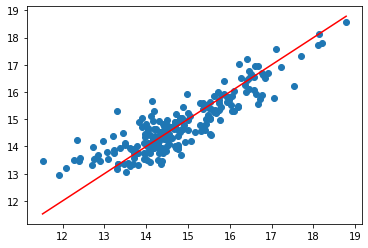

In [24]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_lr)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

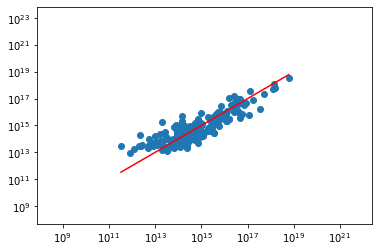

In [25]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_lr)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Ridge CV SiteEnergyUse

In [26]:
#On implémente un modèle de régression Ridge avec cross-validation
n_cv = 300
alphas_cv = np.logspace(-4,4,n_cv)
ridgeCV = RidgeCV(alphas=alphas_cv)
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.06354496e-04, 1.13112788e-04, 1.20300535e-04,
       1.27945027e-04, 1.36075289e-04, 1.44722187e-04, 1.53918552e-04,
       1.63699300e-04, 1.74101565e-04, 1.85164842e-04, 1.96931134e-04,
       2.09445114e-04, 2.22754295e-04, 2.36909207e-04, 2.51963593e-04,
       2.67974609e-04, 2.85003044e-04, 3.03113550e-04, 3.22374888e-04,
       3.42860186e-04, 3.64647222e-0...
       3.10197859e+03, 3.29909369e+03, 3.50873446e+03, 3.73169684e+03,
       3.96882735e+03, 4.22102632e+03, 4.48925126e+03, 4.77452054e+03,
       5.07791724e+03, 5.40059328e+03, 5.74377375e+03, 6.10876161e+03,
       6.49694260e+03, 6.90979055e+03, 7.34887289e+03, 7.81585671e+03,
       8.31251499e+03, 8.84073340e+03, 9.40251743e+03, 1.00000000e+04]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [27]:
#On récupère l'erreur de norme 2 sur le jeu de données test
y_predict_rcv = ridgeCV.predict(X_test)
squared_error_rcv = metrics.mean_squared_error(y_test,y_predict_rcv)
RMSE_rcv = np.sqrt(squared_error_rcv)
print("RMSE : {}".format(RMSE_rcv))

RMSE : 0.5876713614616009


In [28]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_rcv_train = ridgeCV.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_rcv_train))

Coefficient de determination R² : 0.783516550655776


In [29]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_rcv = ridgeCV.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_rcv))

Coefficient de determination R² : 0.7751495366968314


In [30]:
#Alpha le plus performant
best_alpha_cv = ridgeCV.alpha_
print("Best Alpha : {}".format(best_alpha_cv))

Best Alpha : 4.5239562325380485


In [31]:
#Les coefficients du meilleur modèle de régression Ridge
ridgeCV.coef_

array([ 1.77997136e-02, -5.50187036e-03,  9.78359059e-01, -8.61904905e-02,
       -1.08216379e-01,  1.28693064e-01,  9.50383488e-02, -5.15240254e-02,
        3.10594857e-02, -1.91829880e-02,  7.62604502e-02,  2.11314160e-02,
       -1.38827880e-03, -8.44824209e-03,  1.11097138e-01, -3.34909073e-02,
        1.39606891e-02,  5.21181540e-03,  9.15180411e-02,  8.35717080e-04,
        2.60552718e-01, -2.17649621e-01, -1.08313085e-01])

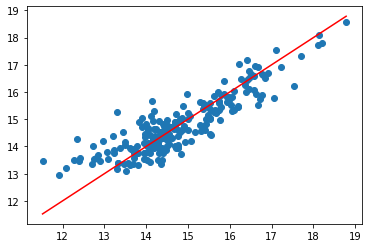

In [32]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_rcv)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

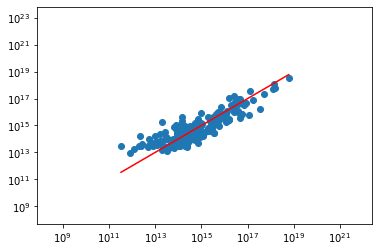

In [33]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_rcv)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Lasso CV SiteEnergyUse

In [34]:
#On implémente un modèle Lasso avec cross-validation
n_lasso = 10
alphas_lasso = np.logspace(-5,5,n_lasso)
lassoCv = LassoCV(alphas=alphas_lasso)
lassoCv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
        copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [35]:
#On récupère l'erreur de norme 2 sur le jeu de données test
y_predict_lasso = lassoCv.predict(X_test)
squared_error_lasso = metrics.mean_squared_error(y_test,y_predict_lasso)
RMSE_lasso = np.sqrt(squared_error_lasso)
print("RMSE : {}".format(np.sqrt(RMSE_lasso)))

RMSE : 0.7664881725467633


In [36]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_lasso_train = lassoCv.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_lasso_train))

Coefficient de determination R² : 0.7834993778319629


In [37]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_lasso = lassoCv.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_lasso))

Coefficient de determination R² : 0.7752774968948417


In [38]:
#Alpha le plus performant
best_alpha_lasso = lassoCv.alpha_
print("Best Alpha : {}".format(best_alpha_lasso))

Best Alpha : 0.0016681005372000592


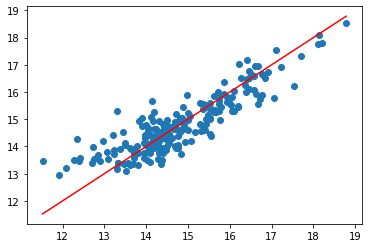

In [39]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_lasso)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

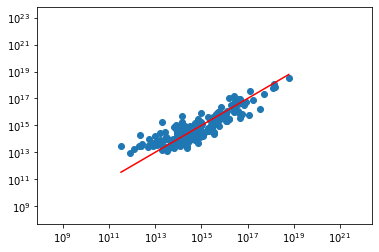

In [40]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_lasso)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Kernel Regression Ridge (kRR) SiteEnergyUse

In [41]:
# valeurs du paramètre alpha
alpha_krr = np.logspace(-10, -5, 6)
# valeurs du paramètre gamma
gamma_krr = np.logspace(-10, -4, 7)

# grille de paramètres
param_grid = {'alpha': alpha_krr, 'gamma': gamma_krr}

# initialiser la validation croisée
grid_krr = GridSearchCV(
        KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring = KernelRidge.score)

grid_krr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05]),
                         'gamma': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function RegressorMixin.score at 0x0000028E297B2A68>,
             verbose=0)

In [42]:
#On récupère l'erreur de norme 2 sur le jeu de données test
y_predict_krr = grid_krr.predict(X_test)
squared_error_krr = metrics.mean_squared_error(y_test,y_predict_krr)
RMSE_krr = np.sqrt(squared_error_krr)
print("RMSE : {}".format(np.sqrt(RMSE_krr)))

RMSE : 0.7698220519649723


In [43]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_krr_train = grid_krr.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_krr_train))

Coefficient de determination R² train : 0.8093832672455158


In [44]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_krr = grid_krr.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_krr))

Coefficient de determination R² : 0.7713421462672868


In [45]:
#Paramêtres les plus performants
best_estimator_knn = grid_krr.best_params_
print(best_estimator_knn)

{'alpha': 1e-07, 'gamma': 1e-05}


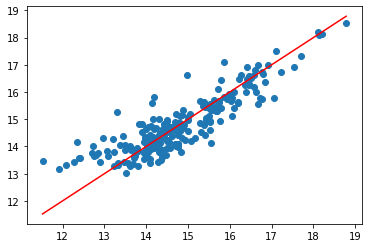

In [46]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_krr)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

## Neural Network SiteEnergyUse

In [47]:
# valeurs du paramètre alpha
alpha_nn = np.logspace(-5, 5, 11)

# grille de paramètres
param_nn = {
            "hidden_layer_sizes": [(50,)], 
            "activation": ["logistic", "tanh"], 
              "solver": ["lbfgs", "adam"],
            "alpha": alpha_nn}

# initialiser la validation croisée
grid_nn = GridSearchCV(
        MLPRegressor(max_iter=500),
        param_nn,
        cv=3,
        scoring='r2')

#On entraine le modèle et on mesure son temps d'execution
start = datetime.datetime.now()
grid_nn.fit(X_train, y_train)
end = datetime.datetime.now()
time_nn = (end - start).total_seconds()

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

In [48]:
#On récupère l'erreur de norme 2 sur le jeu de données test
y_predict_nn = grid_nn.predict(X_test)
squared_error_nn = metrics.mean_squared_error(y_test,y_predict_nn)
RMSE_nn = np.sqrt(squared_error_nn)
print("RMSE : {}".format(np.sqrt(RMSE_nn)))

RMSE : 0.7636293180592347


In [49]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_nn_train = grid_nn.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_nn_train))

Coefficient de determination R² train : 0.8060876135461328


In [50]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_nn = grid_nn.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_nn))

Coefficient de determination R² : 0.7786114742250597


In [51]:
#Paramêtres les plus performants
best_estimator_nn = grid_nn.best_params_
print(best_estimator_nn)

{'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


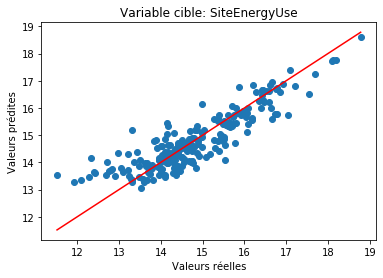

In [52]:
#On compare nos valeurs prédites et nos valeurs réelles
plt.scatter(y_test,y_predict_nn)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Variable cible: SiteEnergyUse")
plt.show()

<br/>
<br/>

# Modèle de prédiction TotalGHGEmissions

In [53]:
#On prépare notre jeu de données et notre valeur à prédire (SiteEnergyUse)
X = data_GHG.iloc[:,:-1]
y = data_GHG.iloc[:,-1]

In [54]:
#On centre et normalise nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [55]:
#On split noyre jeu de données en un jeu de données d'entrainement et un jeu de données test
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=20)

## Baseline (approche naïve)

In [56]:
#On créé une approche naïve avec des prédictions qui sont la moyenne de nos valeurs prédites afin de s'en servir comme base
y_predict_baseline_GHG = np.full(y_test.shape, np.mean(y_test))

squared_error_baseline_GHG = metrics.mean_squared_error(y_test,y_predict_baseline_GHG)
RMSE_baseline_GHG = np.sqrt(squared_error_baseline_GHG)
print("RMSE : {}".format(RMSE_baseline_GHG))

RMSE : 1.535974149788512


## Régression linéaire TotalGHGEmissions

In [57]:
#On implémente un modèle de régression linéaire classique
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
#On stock les valeurs prédites par notre modèle sur le jeu de données test
y_predict_lr = lr.predict(X_test)

In [59]:
# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
squared_error_lr = metrics.mean_squared_error(y_test,y_predict_lr)

print("Erreur quadratique régression linéaire (MSE) : {}".format(squared_error_lr))

Erreur quadratique régression linéaire (MSE) : 0.8428723649074973


In [60]:
RMSE_lr_GHG = np.sqrt(squared_error_lr)
print("RMSE : {}".format(RMSE_lr_GHG))

RMSE : 0.9180808052167834


In [61]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_lr_GHG_train = lr.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_lr_GHG_train))

Coefficient de determination R² : 0.6006072792645171


In [62]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_lr_GHG = lr.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_lr_GHG))

Coefficient de determination R² : 0.6427320963652625


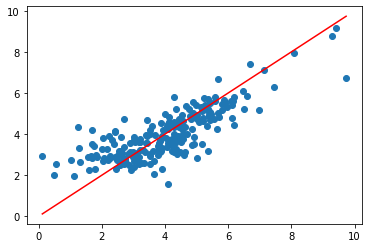

In [63]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_lr)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

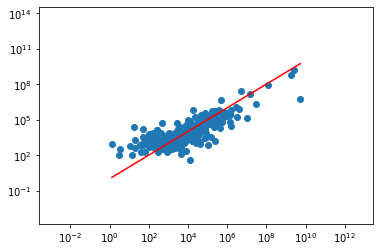

In [64]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_lr)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Ridge CV TotalGHGEmissions

In [65]:
#On implémente un modèle de régression Ridge avec cross-validation
n_cv = 300
alphas_cv = np.logspace(-4,4,n_cv)
ridgeCV = RidgeCV(alphas=alphas_cv)
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.06354496e-04, 1.13112788e-04, 1.20300535e-04,
       1.27945027e-04, 1.36075289e-04, 1.44722187e-04, 1.53918552e-04,
       1.63699300e-04, 1.74101565e-04, 1.85164842e-04, 1.96931134e-04,
       2.09445114e-04, 2.22754295e-04, 2.36909207e-04, 2.51963593e-04,
       2.67974609e-04, 2.85003044e-04, 3.03113550e-04, 3.22374888e-04,
       3.42860186e-04, 3.64647222e-0...
       3.10197859e+03, 3.29909369e+03, 3.50873446e+03, 3.73169684e+03,
       3.96882735e+03, 4.22102632e+03, 4.48925126e+03, 4.77452054e+03,
       5.07791724e+03, 5.40059328e+03, 5.74377375e+03, 6.10876161e+03,
       6.49694260e+03, 6.90979055e+03, 7.34887289e+03, 7.81585671e+03,
       8.31251499e+03, 8.84073340e+03, 9.40251743e+03, 1.00000000e+04]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [66]:
#On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_predict_rcv = ridgeCV.predict(X_test)
squared_error_rcv = metrics.mean_squared_error(y_test,y_predict_rcv)
RMSE_rcv_GHG = np.sqrt(squared_error_rcv)
print("RMSE : {}".format(RMSE_rcv_GHG))

RMSE : 0.9250429531932931


In [67]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_rcv_GHG_train = ridgeCV.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_rcv_GHG_train))

Coefficient de determination R² : 0.5989930896328228


In [68]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_rcv_GHG = ridgeCV.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_rcv_GHG))

Coefficient de determination R² : 0.6372929601681496


In [69]:
#Paramêtre le plus performant
best_alpha_cv_GHG = ridgeCV.alpha_
print("Best Alpha : {}".format(best_alpha_cv_GHG))

Best Alpha : 23.87406771860647


In [70]:
#Les coefficients du meilleur modèle de régression Ridge
ridgeCV.coef_

array([-1.38175707e-01, -8.50003158e-02,  9.80461301e-01, -9.18873184e-02,
        6.35962414e-02,  6.63016792e-03,  1.08371317e-01, -6.45237248e-02,
       -1.11635181e-01,  1.72058703e-01,  2.76511724e-01,  1.06582925e-01,
       -3.86342194e-02, -1.68003719e-02,  4.58756770e-02, -4.04429237e-02,
        7.87707873e-03, -7.29835810e-02,  7.74526179e-02, -1.02631984e-01,
        2.69486363e-02, -3.53643921e-02,  1.52444377e-01, -1.10051094e-01,
        2.73994783e-01, -2.91522176e-01, -1.30818362e-02,  1.00857930e-01,
       -1.01586585e-01, -3.64119057e-02, -5.56209129e-04, -4.74753010e-02,
        4.37395603e-02,  6.43438305e-02,  3.09867184e-02, -3.19724817e-02,
       -1.67361458e-03, -3.13185997e-02, -2.91898485e-02, -7.98884272e-02,
       -4.60270307e-02,  7.61202365e-02,  1.10963203e-01, -4.27278554e-02,
       -5.79297414e-02, -2.56352631e-02,  1.38193241e-02,  4.65620279e-02,
        1.17465875e-02, -5.37305870e-03,  6.34899362e-02, -1.12636894e-01])

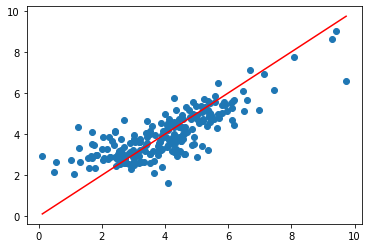

In [71]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_rcv)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

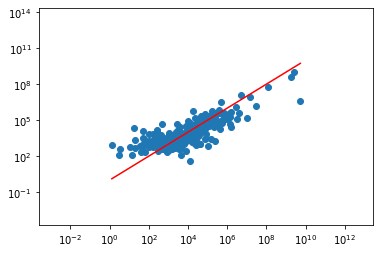

In [72]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_rcv)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Lasso CV TotalGHGEmissions

In [73]:
#On implémente un modèle de régression Lasso avec cross-validation
n_lasso = 11
alphas_lasso = np.logspace(-5,5,n_lasso)
lassoCv = LassoCV(alphas=alphas_lasso)
lassoCv.fit(X_train, y_train)

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.471287984399737, tolerance: 0.14616104390200918
  tol, rng, random, positive)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9142405985971891, tolerance: 0.14996232633711193
  tol, rng, random, positive)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8969987123864485, tolerance: 0.14996232633711193
  tol, rng, random, positive)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. 

LassoCV(alphas=array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
        copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [74]:
#On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_predict_lasso = lassoCv.predict(X_test)
squared_error_lasso = metrics.mean_squared_error(y_test,y_predict_lasso)
RMSE_lasso_GHG = np.sqrt(squared_error_lasso)
print("RMSE : {}".format(np.sqrt(RMSE_lasso_GHG)))

RMSE : 0.9583947474788981


In [75]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_lasso_GHG_train = lassoCv.score(X_train,y_train)
print("Coefficient de determination R² : {}".format(R_2_lasso_GHG_train))

Coefficient de determination R² : 0.5954689680194292


In [76]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_lasso_GHG = lassoCv.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_lasso_GHG))

Coefficient de determination R² : 0.642389809306361


In [77]:
#Paramêtre le plus performant
best_alpha_lasso_GHG = lassoCv.alpha_
print("Best Alpha : {}".format(best_alpha_lasso_GHG))

Best Alpha : 0.01


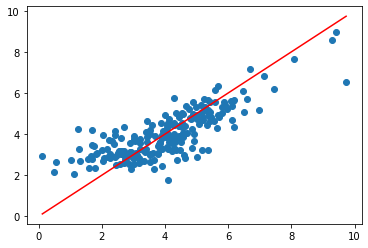

In [78]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_lasso)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

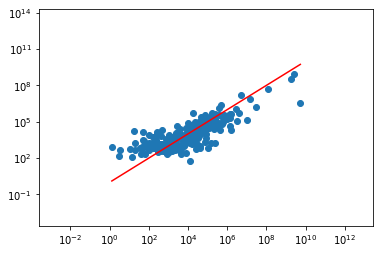

In [79]:
#On compare nos valeurs prédites et nos valeurs réelles(en repassant sur nos valeurs de départ)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(10**y_test,10**y_predict_lasso)
plt.plot([min(10**y_test),max(10**y_test)],[min(10**y_test),max(10**y_test)], "r")
plt.show()

## Kernel Regression Ridge (kRR) TotalGHGEmissions

In [80]:
# valeurs du paramètre alpha
alpha_krr = np.logspace(-10,0, 11)
# valeurs du paramètre gamma
gamma_krr = np.logspace(-10, 0, 11)

# grille de paramètres
param_grid = {'alpha': alpha_krr, 'gamma': gamma_krr}

# initialiser la validation croisée
grid_krr = GridSearchCV(
        KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring = KernelRidge.score)

grid_krr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00]),
                         'gamma': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function RegressorMixin.score at 0x0000028E297B2A68>,
             verbose=0)

In [81]:
#On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_predict_krr = grid_krr.predict(X_test)
squared_error_krr = metrics.mean_squared_error(y_test,y_predict_krr)
RMSE_krr_GHG = np.sqrt(squared_error_krr)
print("RMSE : {}".format(np.sqrt(RMSE_krr_GHG)))

RMSE : 0.9559657825918637


In [82]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_krr_GHG_train = grid_krr.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_krr_GHG_train))

Coefficient de determination R² train : 0.6168792516398989


In [83]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_krr_GHG = grid_krr.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_krr_GHG))

Coefficient de determination R² : 0.6460013733568665


In [84]:
#Paramêtres les plus performants
best_estimator_knn_GHG = grid_krr.best_params_
print(best_estimator_knn_GHG)

{'alpha': 0.001, 'gamma': 0.0001}


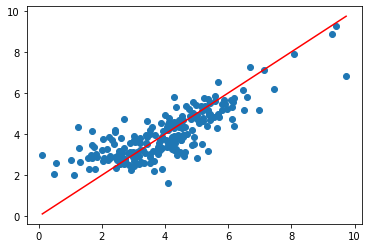

In [85]:
#On compare nos valeurs prédites et nos valeurs réelles
ax = plt.gca()
plt.scatter(y_test,y_predict_krr)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

## Neural Network TotalGHGEmissions

In [86]:
#On implémente un modèle de Neural Network
alpha_nn = np.logspace(-5, 5, 11)

# grille de paramètres
param_nn = {
            "hidden_layer_sizes": [(50,)], 
            "activation": ["logistic", "tanh"], 
              "solver": ["lbfgs", "adam"],
            "alpha": alpha_nn}

# initialiser la validation croisée
grid_nn_GHG = GridSearchCV(
        MLPRegressor(max_iter=500),
        param_nn,
        cv=3,
        scoring='r2')

#On entraine le modèle et on mesure son temps d'execution
start = datetime.datetime.now()
grid_nn_GHG.fit(X_train, y_train)
end = datetime.datetime.now()
time_nn_GHG = (end - start).total_seconds()

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and 

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and 

In [87]:
#On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_predict_nn = grid_nn_GHG.predict(X_test)
squared_error_nn = metrics.mean_squared_error(y_test,y_predict_nn)
RMSE_nn_GHG = np.sqrt(squared_error_nn)
print("RMSE : {}".format(np.sqrt(RMSE_nn_GHG)))

RMSE : 0.9637897672776388


In [88]:
#On calcule R² sur le jeu de données train (le coefficient de determination)
R_2_nn_GHG_train = grid_nn_GHG.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_nn_GHG_train))

Coefficient de determination R² train : 0.6129456371078128


In [89]:
#On calcule R² sur le jeu de données test (le coefficient de determination)
R_2_nn_GHG = grid_nn_GHG.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_nn_GHG))

Coefficient de determination R² : 0.634269288606912


In [90]:
#Paramêtres les plus performants
best_estimator_nn_GHG = grid_nn_GHG.best_params_
print(best_estimator_nn_GHG)

{'activation': 'logistic', 'alpha': 10.0, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


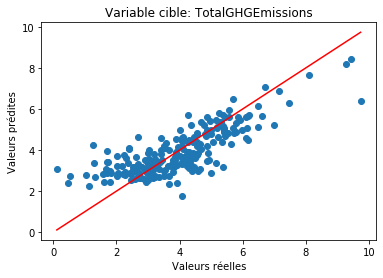

In [91]:
#On compare nos valeurs prédites et nos valeurs réelles
plt.scatter(y_test,y_predict_nn)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Variable cible: TotalGHGEmissions")
plt.show()

## Résultats modèle de prédiction

In [92]:
print("----- SiteEnergyUse -----")
print("Régression classique   RMSE:{} | R² train:{} | R² test:{}".format(round(RMSE_lr,3), round(R_2_lr_train,4), round(R_2_lr,4)))
print("Ridge Régression       RMSE:{} | R² train:{} | R² test:{} | alpha:{}".format(round(RMSE_rcv,3), round(R_2_rcv_train,4), round(R_2_rcv,4), round(best_alpha_cv)))
print("Lasso                  RMSE:{} | R² train:{} | R² test:{} | alpha:{}".format(round(RMSE_lasso,3), round(R_2_lasso_train,4), round(R_2_lasso,4), round(best_alpha_lasso,12)))
print("Kernel Ridge (kRR)     RMSE:{} | R² train:{} | R² test:{} | {}".format(round(RMSE_krr,3), round(R_2_krr_train,4), round(R_2_krr,4), best_estimator_knn))
print("Neural Network (NN)    RMSE:{} | R² train:{} | R² test:{} | {}".format(round(RMSE_nn,3), round(R_2_nn_train,4), round(R_2_nn,4), best_estimator_nn))
print("  ")
print("----- TotalGHGEmissions -----")
print("Régression classique   RMSE:{} | R² train:{} | R² test:{}".format(round(RMSE_lr_GHG,3), round(R_2_lr_GHG_train,4), round(R_2_lr_GHG,4)))
print("Ridge Régression       RMSE:{} | R² train:{} | R² test:{} | alpha:{}".format(round(RMSE_rcv_GHG,3), round(R_2_rcv_GHG_train,4), round(R_2_rcv_GHG,4), round(best_alpha_cv_GHG)))
print("Lasso                  RMSE:{} | R² train:{} | R² test:{} | alpha:{}".format(round(RMSE_lasso_GHG,3), round(R_2_lasso_GHG_train,4), round(R_2_lasso_GHG,4), round(best_alpha_lasso_GHG,12)))
print("Kernel Ridge (kRR)     RMSE:{} | R² train:{} | R² test:{} | {}".format(round(RMSE_krr_GHG,3), round(R_2_krr_GHG_train,4), round(R_2_krr_GHG,4), best_estimator_knn_GHG))
print("Neural Network (NN)    RMSE:{} | R² train:{} | R² test:{} | {}".format(round(RMSE_nn_GHG,3), round(R_2_nn_GHG_train,4), round(R_2_nn_GHG,4), best_estimator_nn_GHG))


----- SiteEnergyUse -----
Régression classique   RMSE:0.588 | R² train:0.7836 | R² test:0.7749
Ridge Régression       RMSE:0.588 | R² train:0.7835 | R² test:0.7751 | alpha:5.0
Lasso                  RMSE:0.588 | R² train:0.7835 | R² test:0.7753 | alpha:0.001668100537
Kernel Ridge (kRR)     RMSE:0.593 | R² train:0.8094 | R² test:0.7713 | {'alpha': 1e-07, 'gamma': 1e-05}
Neural Network (NN)    RMSE:0.583 | R² train:0.8061 | R² test:0.7786 | {'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}
  
----- TotalGHGEmissions -----
Régression classique   RMSE:0.918 | R² train:0.6006 | R² test:0.6427
Ridge Régression       RMSE:0.925 | R² train:0.599 | R² test:0.6373 | alpha:24.0
Lasso                  RMSE:0.919 | R² train:0.5955 | R² test:0.6424 | alpha:0.01
Kernel Ridge (kRR)     RMSE:0.914 | R² train:0.6169 | R² test:0.646 | {'alpha': 0.001, 'gamma': 0.0001}
Neural Network (NN)    RMSE:0.929 | R² train:0.6129 | R² test:0.6343 | {'activation': 'logistic', 'alp

# Modèles choisis avec l'ENERGY STAR SCORE

In [93]:
# On prépare les dataframes
data_energy_ESS = data_opt[['PrimaryPropertyType',
       'YearBuilt','NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking','ENERGYSTARScore','SiteEnergyUse']]

data_GHG_ESS = data_opt[['BuildingType','PrimaryPropertyType', 'CouncilDistrictCode','Neighborhood',
       'YearBuilt','NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking','ENERGYSTARScore','TotalGHGEmissions']]

In [94]:
data_energy_ESS.loc[data_energy_ESS['PropertyGFAParking'] <= 0, 'PropertyGFAParking'] = min(data_energy_ESS[data_energy_ESS['PropertyGFAParking'] > 0]['PropertyGFAParking'])
data_energy_ESS.loc[data_energy_ESS['NumberofFloors'] <= 0, 'NumberofFloors'] = min(data_energy_ESS[data_energy_ESS['NumberofFloors'] > 0]['NumberofFloors'])
data_energy_ESS = data_energy_ESS.loc[data_energy_ESS['SiteEnergyUse'] > 0]


data_energy_ESS.loc[:,'PropertyGFATotal'] = np.log(data_energy_ESS['PropertyGFATotal'])
data_energy_ESS.loc[:,'PropertyGFAParking'] = np.log(data_energy_ESS['PropertyGFAParking'])
data_energy_ESS.loc[:,'YearBuilt'] = np.log(data_energy_ESS['YearBuilt'])
data_energy_ESS.loc[:,'NumberofFloors'] = np.log(data_energy_ESS['NumberofFloors'])
data_energy_ESS.loc[:,'ENERGYSTARScore'] = np.log(data_energy_ESS['ENERGYSTARScore'])
data_energy_ESS.loc[:,'SiteEnergyUse'] = np.log(data_energy_ESS['SiteEnergyUse'])

C:\Users\yacin\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [95]:
data_GHG_ESS.loc[data_GHG_ESS['PropertyGFAParking'] <= 0, 'PropertyGFAParking'] = min(data_GHG_ESS[data_GHG_ESS['PropertyGFAParking'] > 0]['PropertyGFAParking'])
data_GHG_ESS.loc[data_GHG_ESS['NumberofFloors'] <= 0, 'NumberofFloors'] = min(data_GHG_ESS[data_GHG_ESS['NumberofFloors'] > 0]['NumberofFloors'])
data_GHG_ESS = data_GHG_ESS.loc[data_GHG_ESS['TotalGHGEmissions'] > 0]


data_GHG_ESS.loc[:,'PropertyGFATotal'] = np.log(data_GHG_ESS['PropertyGFATotal'])
data_GHG_ESS.loc[:,'PropertyGFAParking'] = np.log(data_GHG_ESS['PropertyGFAParking'])
data_GHG_ESS.loc[:,'YearBuilt'] = np.log(data_GHG_ESS['YearBuilt'])
data_GHG_ESS.loc[:,'NumberofFloors'] = np.log(data_GHG_ESS['NumberofFloors'])
data_GHG_ESS.loc[:,'ENERGYSTARScore'] = np.log(data_GHG_ESS['ENERGYSTARScore'])
data_GHG_ESS.loc[:,'TotalGHGEmissions'] = np.log(data_GHG_ESS['TotalGHGEmissions'])

In [96]:
#On transforme les valeurs qualitatives en valeurs quantitatives
data_energy_ESS = pd.get_dummies(data_energy_ESS)

In [97]:
#On transforme les valeurs qualitatives en valeurs quantitatives
data_GHG_ESS = pd.get_dummies(data_GHG_ESS)

In [98]:
#On déplace notre colonne cible à la fin
new_index = data_energy_ESS.columns[data_energy_ESS.columns != "SiteEnergyUse"].append(pd.Index(["SiteEnergyUse"]))
data_energy_ESS = data_energy_ESS[new_index]

In [99]:
#On déplace notre colonne cible à la fin
new_index = data_GHG_ESS.columns[data_GHG_ESS.columns != "TotalGHGEmissions"].append(pd.Index(["TotalGHGEmissions"]))
data_GHG_ESS = data_GHG_ESS[new_index]

## Neural Network SiteEnergyUse AVEC Energy Star Score

In [100]:
X = data_energy_ESS.iloc[:,:-1]
y = data_energy_ESS.iloc[:,-1]

In [101]:
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=50)

In [103]:
alpha_nn = np.logspace(-5, 5, 11)

param_nn = {
            "hidden_layer_sizes": [(50,)], 
            "activation": ["logistic", "tanh"], 
              "solver": ["lbfgs", "adam"],
            "alpha": alpha_nn}

# initialiser la validation croisée
grid_nn = GridSearchCV(
        MLPRegressor(max_iter=500),
        param_nn,
        cv=3,
        scoring='r2')

grid_nn.fit(X_train, y_train)

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_pe

C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\yacin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=500, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=...
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh'],
                         'alpha': array([1.e-05, 1.e-04

In [104]:
# prédire sur le jeu de test avec le modèle sélectionné 
y_predict_nn_ESS = grid_nn.predict(X_test)
squared_error_nn_ESS = metrics.mean_squared_error(y_test,y_predict_nn_ESS)
RMSE_nn_ESS = np.sqrt(squared_error_nn_ESS)
print("RMSE : {}".format(np.sqrt(RMSE_nn_ESS)))

RMSE : 0.6929525773451116


In [105]:
R_2_nn_train_ESS = grid_nn.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_nn_train_ESS))

Coefficient de determination R² train : 0.9026194169765757


In [106]:
R_2_nn_ESS = grid_nn.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_nn_ESS))

Coefficient de determination R² : 0.8498799189510036


In [107]:
best_estimator_nn_ESS = grid_nn.best_params_
print(best_estimator_nn_ESS)

{'activation': 'logistic', 'alpha': 1.0, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}


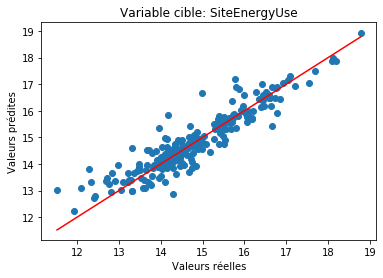

In [108]:
plt.scatter(y_test,y_predict_nn_ESS)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Variable cible: SiteEnergyUse")
plt.show()

## Kernel Regression Ridge (kRR) TotalGHGEmissions AVEC Energy Star Score

In [109]:
X = data_GHG_ESS.iloc[:,:-1]
y = data_GHG_ESS.iloc[:,-1]

In [110]:
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, train_size=0.8, random_state=50)

In [112]:
# valeurs du paramètre alpha
alpha_krr = np.logspace(-10,0, 11)
# valeurs du paramètre gamma
gamma_krr = np.logspace(-10, 0, 11)

# grille de paramètres
param_grid = {'alpha': alpha_krr, 'gamma': gamma_krr}

# initialiser la validation croisée
grid_krr = GridSearchCV(
        KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring = KernelRidge.score)

grid_krr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='rbf', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00]),
                         'gamma': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function RegressorMixin.score at 0x0000028E297B2A68>,
             verbose=0)

In [113]:
# prédire sur le jeu de test avec le modèle sélectionné 
y_predict_krr_ESS = grid_krr.predict(X_test)
squared_error_krr_ESS = metrics.mean_squared_error(y_test,y_predict_krr_ESS)
RMSE_krr_ESS_GHG = np.sqrt(squared_error_krr_ESS)
print("RMSE : {}".format(np.sqrt(RMSE_krr_ESS_GHG)))

RMSE : 0.9526436065082727


In [114]:
R_2_krr_ESS_GHG_train = grid_krr.score(X_train,y_train)
print("Coefficient de determination R² train : {}".format(R_2_krr_ESS_GHG_train))

Coefficient de determination R² train : 0.7094859571094754


In [115]:
R_2_krr_ESS_GHG = grid_krr.score(X_test,y_test)
print("Coefficient de determination R² : {}".format(R_2_krr_ESS_GHG))

Coefficient de determination R² : 0.6565984133175564


In [116]:
best_estimator_knn_ESS_GHG = grid_krr.best_params_
print(best_estimator_knn_ESS_GHG)

{'alpha': 1e-06, 'gamma': 1e-05}


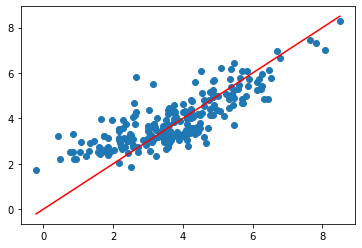

In [117]:
ax = plt.gca()
plt.scatter(y_test,y_predict_krr_ESS)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], "r")
plt.show()

In [118]:
print("----- SiteEnergyUse -----")
print("Neural Network (NN)    RMSE:{} | R² train:{} | R² test:{}".format(round(RMSE_nn_ESS,3), round(R_2_nn_train_ESS,4), round(R_2_nn_ESS,4)))
print("{}".format(best_estimator_nn_ESS))
print("  ")
print("----- TotalGHGEmissions -----")
print("Kernel Ridge (kRR)     RMSE:{} | R² train:{} | R² test:{}".format(round(RMSE_krr_ESS_GHG,3), round(R_2_krr_ESS_GHG_train,4), round(R_2_krr_ESS_GHG,4)))
print("{}".format(best_estimator_knn_ESS_GHG))

----- SiteEnergyUse -----
Neural Network (NN)    RMSE:0.48 | R² train:0.9026 | R² test:0.8499
{'activation': 'logistic', 'alpha': 1.0, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}
  
----- TotalGHGEmissions -----
Kernel Ridge (kRR)     RMSE:0.908 | R² train:0.7095 | R² test:0.6566
{'alpha': 1e-06, 'gamma': 1e-05}
